# Introduction

This code cell is used for creating a base interactions data to create a synthetic data generator for `interactions.csv`. It assumes that the only type of interaction is purchases.

# Utils

The code cells below setup the neccessary imports, utils, and constants.

In [80]:
# for reading excel file with pandas
!pip install openpyxl gensim

import os
import csv
import json
import utils
import numpy as np
import pandas as pd
import seaborn as sns
import gensim.downloader
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

PROJECT_DIR = "."
DATASET_DIR = os.path.join(PROJECT_DIR, "datasets")
SOURCES_DIR = os.path.join(PROJECT_DIR, "sources")

os.makedirs(DATASET_DIR, exist_ok=True) # create datasets dir if does not exist

Defaulting to user installation because normal site-packages is not writeable


In [81]:
def assign_nosh_product_id_to_opensource_products(products, nosh_products):
    """ Assign an id from nosh products to opensource products data.
    
    Args:
    ---
    - `products`: List[str]
        The list of products in open source data.
    - `nosh_products`: DataFrame
        The nosh product DataFrame
        
    Returns:
    ---
    DataFrame
        A DataFrame with columns `nosh_product_id`, `nosh_product`, `product`
    """
    p = []
    for product in products:
        match = utils.match_closest_nosh_product(product, nosh_products)
        p.append(match)
    return pd.DataFrame(p)[['nosh_product_id', 'nosh_product', 'product']]

# Building Base Purchases Data

Read nosh products and purchases data

In [82]:
nosh_products = utils.read_nosh_products(os.path.join(SOURCES_DIR, "nosh_product_data.xlsx"))
nosh_purchases = utils.read_nosh_purchases(os.path.join(SOURCES_DIR, "nosh_purchase_data.xlsx"))

In [83]:
nosh_products.head()

,product_id,product,shelf_life,usual_storage
0,1,spaghetti,NaN,pantry
1,2,onion,13.0,pantry
2,3,sugar,NaN,pantry
3,4,mustard,60.0,pantry
4,5,tomato sauce,NaN,pantry


In [84]:
nosh_purchases.head()

,customer_id,product_id,timestamp
0,1,12,2022-12-22
1,1,12,2022-05-28
2,1,31,2022-11-27
3,1,31,2022-09-01
4,1,34,2022-11-03


Read opensource purchases and products data

In [85]:
opensource_purchases = utils.read_opensource_purchases(os.path.join(SOURCES_DIR, "Groceries_dataset.csv"))

In [86]:
opensource_purchases.head()

,customer_id,product_name,timestamp
8395,1000,whole milk,2015-03-15
13331,1000,whole milk,2014-06-24
2047,1000,canned beer,2015-07-24
24544,1000,yogurt,2015-03-15
1629,1000,soda,2015-05-27


In [87]:
opensource_products = assign_nosh_product_id_to_opensource_products(
    products=opensource_purchases['product_name'].unique(),
    nosh_products=nosh_products,
)

In [88]:
opensource_products.head()

,nosh_product_id,nosh_product,product
0,141,milk,whole milk
1,161,beer,canned beer
2,38,chocolate breakfast cereal,yogurt
3,161,beer,soda
4,161,beer,misc. beverages


The open source purchase data contains products in the form of product name with some products not existing in nosh products list. Therefore, we need to match these open source product names with nosh products

After we assign nosh product id to open source products, we can merge it back to the opensource purchases data to get product id in the purchase sequences

In [89]:
opensource_purchases = opensource_purchases.merge(
    right=opensource_products,
    left_on='product_name',
    right_on='product',
    how='left'
)
opensource_purchases = opensource_purchases[['customer_id', 'nosh_product_id', 'timestamp']].rename(columns={"nosh_product_id": "product_id"})

In [90]:
opensource_purchases.head()

,customer_id,product_id,timestamp
0,1000,141,2015-03-15
1,1000,141,2014-06-24
2,1000,161,2015-07-24
3,1000,38,2015-03-15
4,1000,161,2015-05-27


Now we have converted the open source purchase data to have the same nosh products id. Hence, we can add the open source purchase data to nosh purchases data.

In [91]:
purchases_data = pd.concat([nosh_purchases, opensource_purchases])\
                .merge(right=nosh_products, left_on='product_id', right_on='product_id', how='left')\
                .drop(columns=['shelf_life', 'usual_storage'], axis=-1)

purchases_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38936 entries, 0 to 38935
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   customer_id  38936 non-null  int64         
 1   product_id   38936 non-null  int64         
 2   timestamp    38936 non-null  datetime64[ns]
 3   product      38936 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 1.5+ MB


In [92]:
purchases_data.head()

,customer_id,product_id,timestamp,product
0,1,12,2022-12-22,pappardelle pasta
1,1,12,2022-05-28,pappardelle pasta
2,1,31,2022-11-27,tea
3,1,31,2022-09-01,tea
4,1,34,2022-11-03,wholemeal flour


In [93]:
purchases_data.tail()

,customer_id,product_id,timestamp,product
38931,5000,37,2015-02-10,pita bread
38932,5000,2,2014-03-09,onion
38933,5000,161,2015-02-10,beer
38934,5000,200,2014-03-09,fruit juice
38935,5000,205,2015-02-10,broccoli


# Save csv files

**purchase_sequences_{train/test}.csv**

The code cells below is used for creating the base purchase sequence csv files.

In [94]:
purchase_sequences = purchases_data.groupby(['customer_id', 'timestamp'])['product_id']\
            .apply(lambda x: x.tolist())\
            .to_frame(name = 'purchase_sequence')\
            .reset_index()

purchase_sequences = purchase_sequences[purchase_sequences['purchase_sequence'].str.len() > 1]\
                        .drop(['customer_id', 'timestamp'], axis=1).reset_index(drop=True)
purchase_sequences['purchase_sequence'] = purchase_sequences['purchase_sequence'].apply(lambda x: ",".join([str(i) for i in x]))

In [95]:
purchase_sequences.head()

,purchase_sequence
0,"141,86,38"
1,"141,38,116,37"
2,"161,180"
3,"161,161"
4,"51,186,141,116"


In [96]:
purchase_sequences.to_csv(os.path.join(DATASET_DIR, "purchase_sequences.csv"), index=False)

To match the distribution of this base data, the synthetic data generator might want to know two things:

1. The distribution of the product of the base data.
2. The distribution of the number of purchases made in a session.

**product_count_dist.csv**

The code cell below is used for creating the distribution of products.

In [101]:
product_count_dist = purchases_data.copy()
product_count_dist = product_count_dist.groupby(['product_id'])['product_id']\
                        .count()\
                        .to_frame(name = 'count').reset_index()
product_count_dist = nosh_products[['product_id']].merge(
                        right=product_count_dist,
                        left_on='product_id',
                        right_on='product_id',
                        how='left'
                    )
product_count_dist['count'] = product_count_dist['count'].fillna(product_count_dist['count'].min())

In [107]:
product_count_dist

,product_id,count
0,1,391.0
1,2,305.0
2,3,294.0
3,4,92.0
4,5,5.0
...,...,...
202,206,6.0
203,207,5.0
204,208,5.0
205,209,662.0


In [103]:
product_count_dist.to_csv(os.path.join(DATASET_DIR, "product_count_dist.csv"), index=False)

**purchase_count_dist.csv**

The code cell below is used for creating the distribution of how many purchases is bought in a session.

In [104]:
purchase_count_dist = purchases_data.copy()
purchase_count_dist = purchase_count_dist.groupby(['customer_id', 'timestamp'])['product']\
                                        .count()\
                                        .to_frame(name = 'count').reset_index()
purchase_count_dist = purchase_count_dist.groupby(['count'])['count']\
                                        .count()\
                                        .to_frame(name = 'value').reset_index()

In [105]:
purchase_count_dist.to_csv(os.path.join(DATASET_DIR, "purchase_count_dist.csv"), index=False)

# Visualisation

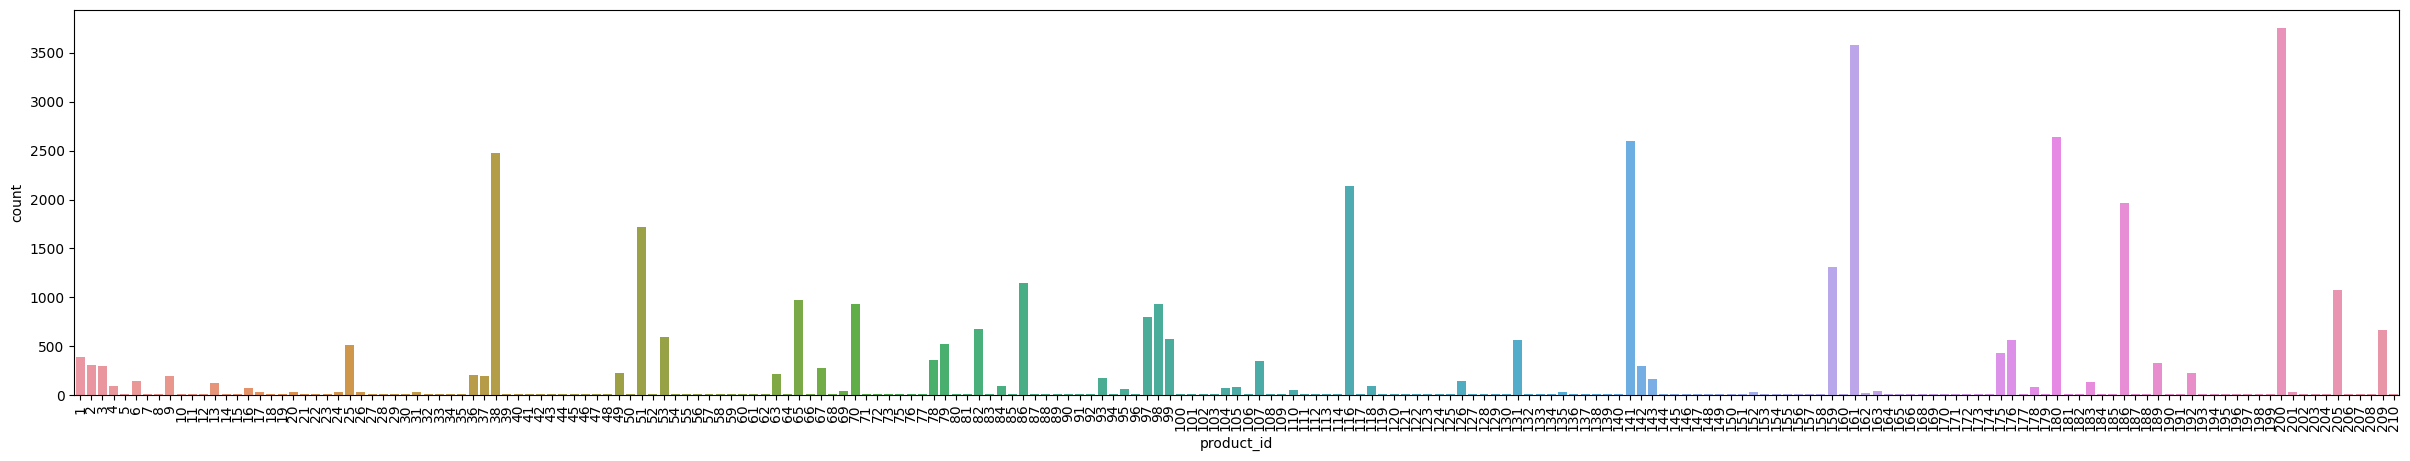

In [108]:
fig = plt.figure(figsize=(30, 5))
sns.barplot(data=product_count_dist, x='product_id', y='count')
_ = plt.xticks(rotation=90)
plt.show()

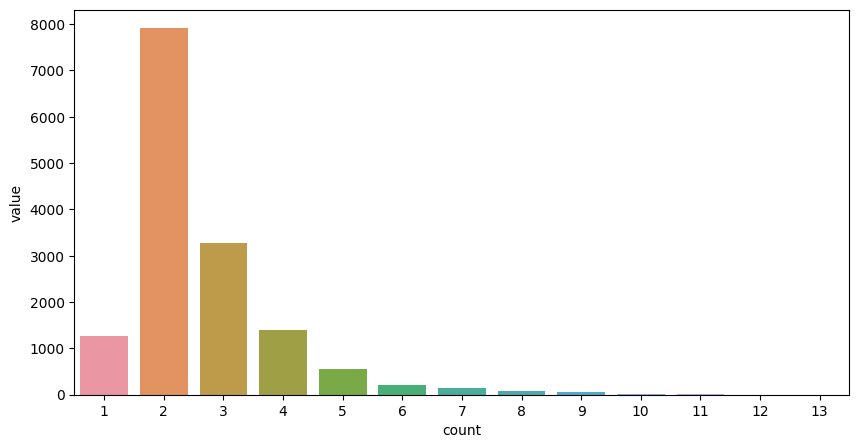

In [109]:
fig = plt.figure(figsize=(10, 5))
sns.barplot(data=purchase_count_dist, x='count', y='value')
plt.show()